# Import Dependencies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sodapy import Socrata
from datetime import datetime
import os

import matplotlib.pyplot as plt
from textwrap import wrap

# Extract Data from Data.lacity.org

 - Documentation: https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua
 - Label: "6rrh-rzua"

In [ ]:
# Example authenticated client (needed for non-public datasets):
MyAppToken = 's1gpVsyovUdhCzhVOCnZzNdQm'
client = Socrata("data.lacity.org",
                 MyAppToken,
                 username="dr3nf0h20ugns8nr1tyqzkz42",
                 password="4x4c3k4lhiowphlbs1t52ezc4psshb1fg9ck9fbdii1ok925qu")

## Filter Data for Instances Between 2015-01-01 to 2020-07-15

In [ ]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
columns = '''
business_name, street_address, city, zip_code, 
location_description, primary_naics_description, council_district, 
location_start_date, location_1
'''
dates = '''location_start_date BETWEEN '2015-01-10T12:00:00' AND '2020-07-15T12:00:00'
'''
results = client.get("6rrh-rzua",select=columns, where=dates, offset=1000, limit=500000)

# Load Data into Pandas

In [ ]:
# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
# Convert location column and extract lat and lng
df = pd.concat([df.drop(['location_1'], axis=1), df['location_1'].apply(pd.Series)], axis=1)
df.drop(columns=[0,'human_address'], inplace =True)

# Transform Data

 - Convert datatypes
 - Add new columns

In [ ]:
# Convert location_start_date into datetime datatype
df['location_start_date'] = df['location_start_date'].astype('datetime64[ns]') 

In [ ]:
# Drop missing start date
df.dropna(subset=['location_start_date'], inplace=True)

In [ ]:
# Add columns
df['start_year'] = pd.DatetimeIndex(df['location_start_date']).year
df['month_year'] = pd.to_datetime(df['location_start_date']).dt.to_period('M')

# Save Data into CSV File

In [ ]:
# Save File
df.to_csv("/Users/trinitycisneros/Documents/Coding/bitterscientist.com/la_active_bus.csv", index=False)

# Load CSV File Data <font color="red">df</font>

In [2]:
file = "/Users/trinitycisneros/Documents/Coding/bitterscientist.com/la_active_bus.csv"
df = pd.read_csv(file)

# Filter Data for Jan - July for each Year 2015-2020

In [3]:
jan_july_df = df.loc[(df['month_year'] >='2015-01') & (df['month_year'] < '2015-07') | 
                     (df['month_year'] >='2016-01') & (df['month_year'] < '2016-07') |
                     (df['month_year'] >='2017-01') & (df['month_year'] < '2017-07') |
                     (df['month_year'] >='2018-01') & (df['month_year'] < '2018-07') |
                     (df['month_year'] >='2019-01') & (df['month_year'] < '2019-07') |
                     (df['month_year'] >='2020-01') & (df['month_year'] < '2020-07')]

# Questions

 - How have the number of new businesses per year changed
 - What is the percent change of new business per year
 - What are the time cohorts and their percent change per year
 - Does the business classification affect the number of new business per year?
 - Which are the cities with the highest number of new businesses?
 - How have the number of new businesses changed over the years for these top cities?

# <font color="blue">Question 1:</font> How have the Total Number of New Active Businesses Changed Between 2015 - 2020

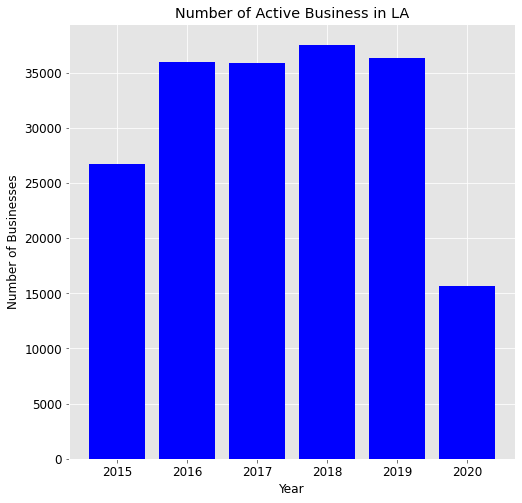

In [4]:
act_by_year = df.groupby("start_year").size()
%matplotlib inline
plt.style.use('ggplot')

x = act_by_year.index.values
nbr_businesses = act_by_year.values
x_pos = [i for i, _ in enumerate(x)]

fig, axes = plt.subplots(1,1, figsize=(8,8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
axes.bar(x_pos, nbr_businesses, color='blue')
axes.set_xlabel("Year", color="black")
axes.set_ylabel("Number of Businesses", color="black")
axes.set_title("Number of Active Business in LA",color="black")
axes.set_xticks(range(6))
axes.set_xticklabels([year for year in x], color="black")
axes.tick_params(axis="y", labelsize=12, labelcolor="black")
axes.tick_params(axis="x", labelsize=12, labelcolor="black")

plt.savefig("images/figure1.png", bbox_inches='tight')

plt.show()

# Compare New Active Businesses Between Jan - July for Each Year

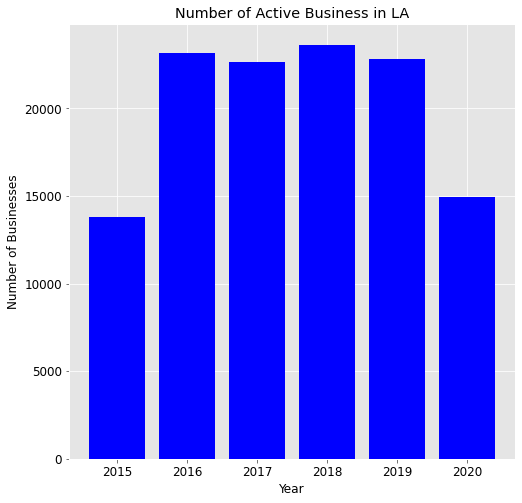

In [5]:
act_by_year = jan_july_df.groupby("start_year").size()
%matplotlib inline
plt.style.use('ggplot')

x = act_by_year.index.values
nbr_businesses = act_by_year.values
x_pos = [i for i, _ in enumerate(x)]

fig, axes = plt.subplots(1,1, figsize=(8,8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
axes.bar(x_pos, nbr_businesses, color='blue')
axes.set_xlabel("Year", color="black")
axes.set_ylabel("Number of Businesses", color="black")
axes.set_title("Number of Active Business in LA",color="black")
axes.set_xticks(range(6))
axes.set_xticklabels([year for year in x], color="black")
axes.tick_params(axis="y", labelsize=12, labelcolor="black")
axes.tick_params(axis="x", labelsize=12, labelcolor="black")

plt.savefig("images/figure1b.png", bbox_inches='tight')

plt.show()

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
    
 - The number of new active businesses was over 25,000 between 2015-2019, and by july 2020, is nearly half.
</div>

<hr style='border-top: 4px solid black;'>

# <font color="blue">Question 2:</font> What is the total number of active business by city per year?

 - Limited to the 20 cities with the highest number of active businesses in dataset

In [6]:
print('The total number of cities in this dataset are: {}'.format(len(df.city.unique())))

The total number of cities in this dataset are: 1672


### Limit the number of cities to analyze to the top 20

In [7]:
# Prepare a dataframe that only contains the city, year, and number of businesses
city_numbers_df = df.groupby(['city', 'start_year']).size()
city_numbers_df = city_numbers_df.reset_index()
city_numbers_df.columns = ["city", "year", "count"]

# Find out which of these cities have the highest number of new businesses and filter for the top 20
top_20_cities = city_numbers_df.groupby('city')["count"].sum().sort_values(ascending=False).nlargest(20)
top_20_city_names = top_20_cities.index.values

<div style="border:1px solid black; padding:10px">
<font color="blue">Top 20 cities:</font><br>
'LOS ANGELES', 'VAN NUYS', 'NORTH HOLLYWOOD', 'SHERMAN OAKS',
       'WOODLAND HILLS', 'ENCINO', 'NORTHRIDGE', 'STUDIO CITY',
       'CANOGA PARK', 'RESEDA', 'TARZANA', 'VENICE', 'PANORAMA CITY',
       'SYLMAR', 'SAN PEDRO', 'SUN VALLEY', 'GRANADA HILLS', 'CHATSWORTH',
       'VALLEY VILLAGE', 'PACOIMA'
</div>

<hr style='border-top: 2px solid black;'>

# Filter <font color="red">df</font> dataframe so that it only include the 20 cities with the highest number of new businesses <font color="red">top_20_df</font> 

In [8]:
# Dataframe that contains only the top 20 cities
top_20_df = df[df['city'].isin(top_20_city_names)]

## Groupby new filtered dataframe by start year and city, and then count the 'start year'

In [9]:
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [10]:
top_20_cities_df = top_20_df.groupby(["start_year", "city"])["start_year"].agg(["count"])
top_20_cities_df = top_20_cities_df.reset_index()

In [11]:
# Create a pivot table from the groupby dataframe
table = pd.pivot_table(top_20_cities_df, values='count', index='city', columns=['start_year'], aggfunc='sum')
table

start_year,2015,2016,2017,2018,2019,2020
city,,,,,,
CANOGA PARK,274,445,447,470,467,182
CHATSWORTH,233,297,310,315,279,101
ENCINO,590,686,675,759,672,213
GRANADA HILLS,231,342,301,307,321,114
LOS ANGELES,13318,17874,17667,18241,17113,7296
NORTH HOLLYWOOD,936,1241,1255,1256,1208,560
NORTHRIDGE,381,553,527,557,528,239
PACOIMA,200,271,251,290,263,116
PANORAMA CITY,249,375,343,316,364,167


In [12]:
pct_change_table = table.pct_change(axis='columns')*100
pct_change_table.style.applymap(color_negative_red)

start_year,2015,2016,2017,2018,2019,2020
city,,,,,,
CANOGA PARK,nan,62.4088,0.449438,5.14541,-0.638298,-61.0278
CHATSWORTH,nan,27.4678,4.3771,1.6129,-11.4286,-63.7993
ENCINO,nan,16.2712,-1.6035,12.4444,-11.4625,-68.3036
GRANADA HILLS,nan,48.0519,-11.9883,1.99336,4.56026,-64.486
LOS ANGELES,nan,34.2093,-1.15811,3.249,-6.18387,-57.3657
NORTH HOLLYWOOD,nan,32.5855,1.12812,0.0796813,-3.82166,-53.6424
NORTHRIDGE,nan,45.1444,-4.70163,5.6926,-5.20646,-54.7348
PACOIMA,nan,35.5,-7.38007,15.5378,-9.31034,-55.8935
PANORAMA CITY,nan,50.6024,-8.53333,-7.87172,15.1899,-54.1209


In [13]:
max_change = pct_change_table[2020].max()
min_change = pct_change_table[2020].min()
mean_change = pct_change_table[2020].mean()
max_change_city = pct_change_table[pct_change_table[2020] == max_change].index.values[0]
min_change_city = pct_change_table[pct_change_table[2020] == min_change].index.values[0]
print('The city with the larged drop in new businesses was {} at {}%\nThe city with the smallest drop in new business was {} at {}%\nThe mean change in new businesses was {}%'.format(max_change_city, round(max_change), min_change_city, round(min_change), round(mean_change)))

The city with the larged drop in new businesses was SAN PEDRO at -45.0%
The city with the smallest drop in new business was ENCINO at -68.0%
The mean change in new businesses was -59.0%


<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
 - All of the top cities studies had a negative percent change <br>
 - Encino has the smallest drop (-45%)<br>
 - San Pedro had the highest drop (-68%)<br>
 - The mean percent change was -59%.<br>
</div>

# Compare the change in new business by city within the same period Jan - July for each year (2015-2020)

In [14]:
# Dataframe that contains only the top 20 cities
top_20_df = jan_july_df[jan_july_df['city'].isin(top_20_city_names)]
top_20_cities_df = top_20_df.groupby(["start_year", "city"])["start_year"].agg(["count"])
top_20_cities_df = top_20_cities_df.reset_index()

In [15]:
# Create a pivot table from the groupby dataframe
table = pd.pivot_table(top_20_cities_df, values='count', index='city', columns=['start_year'], aggfunc='sum')
pct_change_table = table.pct_change(axis='columns')*100
pct_change_table.style.applymap(color_negative_red)

start_year,2015,2016,2017,2018,2019,2020
city,,,,,,
CANOGA PARK,nan,101.527,1.13636,10.8614,1.68919,-42.5249
CHATSWORTH,nan,76.1468,3.125,3.53535,-15.122,-44.2529
ENCINO,nan,51.7361,-3.89016,15.2381,-2.89256,-57.8723
GRANADA HILLS,nan,95.614,-13.4529,1.03627,8.71795,-49.0566
LOS ANGELES,nan,65.3807,-2.411,3.63896,-7.10843,-35.3622
NORTH HOLLYWOOD,nan,74.5342,0,-10.4389,1.5894,-31.6819
NORTHRIDGE,nan,95.6757,-11.6022,5.9375,4.71976,-37.7465
PACOIMA,nan,50,-8.06452,13.4503,-8.76289,-37.2881
PANORAMA CITY,nan,98.4375,-7.08661,-14.8305,17.4129,-34.7458


<hr style='border-top: 4px solid black;'>

# <font color="blue">Question 3:</font> How have the number of new businesses change by city between 2015-2020

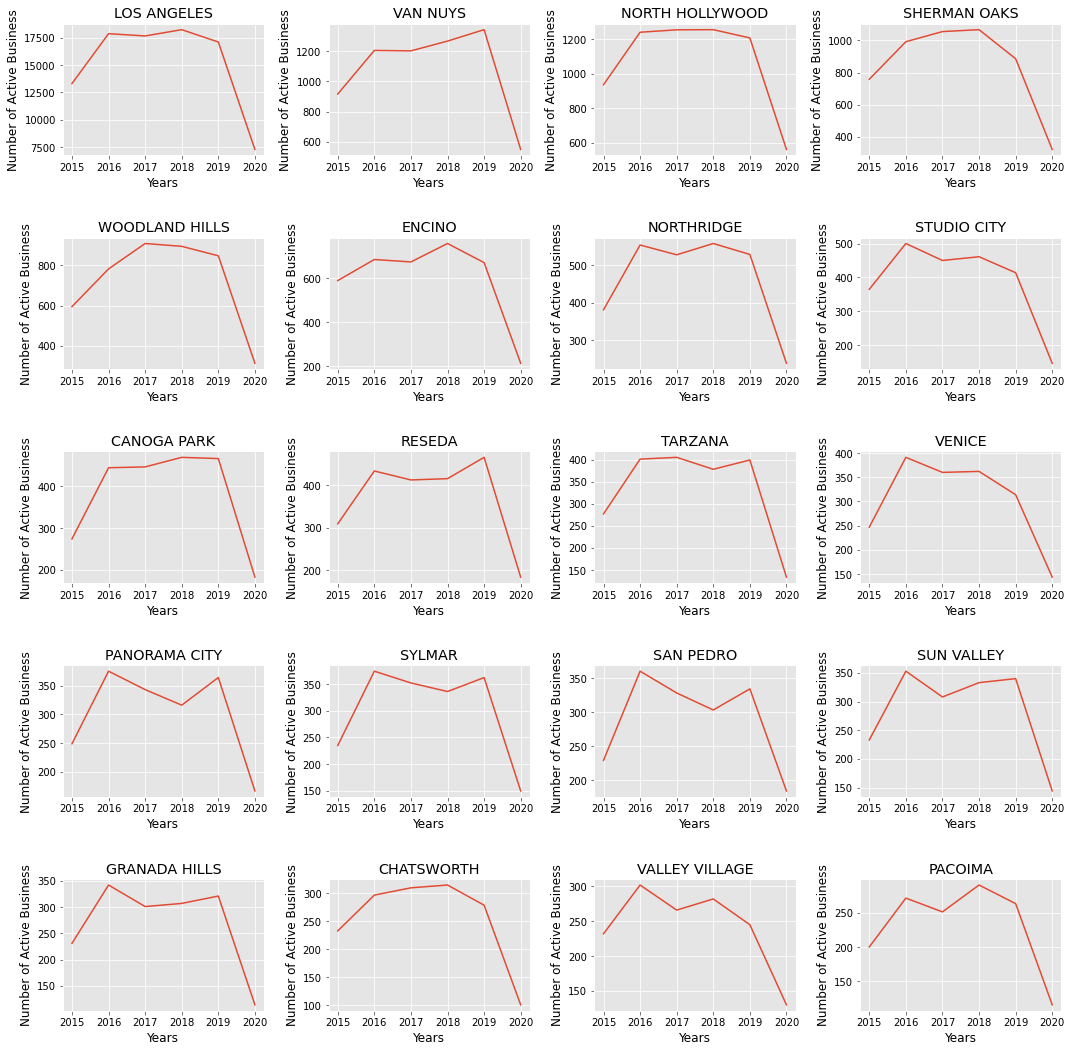

In [17]:
nbr_cities = len(top_20_city_names)
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=1, wspace=0.2)
for city, num in zip(top_20_city_names, range(1,nbr_cities+1)):
    
    # Gets the data for the individual city
    city_df=df[df['city']==city]
    city_year_data = city_df.groupby('start_year').size()
    years = city_year_data.index.values
    number_businesses = city_year_data.values
    
    ax = fig.add_subplot(5,4, num)
    ax.plot(years, number_businesses)
    ax.set_ylabel('Number of Active Business', color="black")
    ax.set_xlabel('Years', color="black")
    ax.set_title(city)
    ax.tick_params(axis="y", labelcolor="black")
    ax.tick_params(axis="x", labelcolor="black")

plt.tight_layout()
plt.savefig("images/figure2.png", bbox_inches='tight')    
plt.show()

# Fever Plots for New Business by City and Year between Jan - July

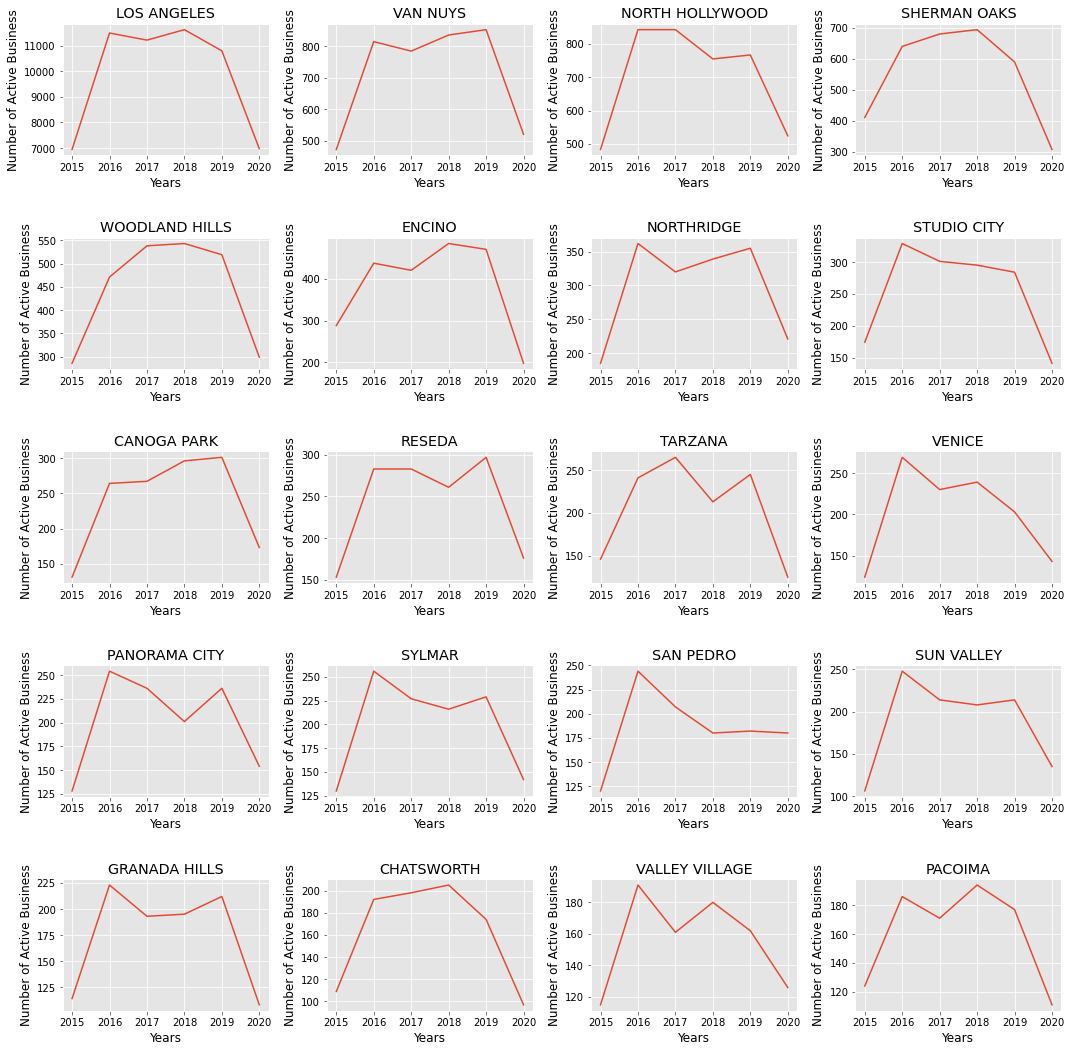

In [20]:
nbr_cities = len(top_20_city_names)
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=1, wspace=0.2)
for city, num in zip(top_20_city_names, range(1,nbr_cities+1)):
    
    # Gets the data for the individual city
    city_df=jan_july_df[jan_july_df['city']==city]
    city_year_data = city_df.groupby('start_year').size()
    years = city_year_data.index.values
    number_businesses = city_year_data.values
    
    ax = fig.add_subplot(5,4, num)
    ax.plot(years, number_businesses)
    ax.set_ylabel('Number of Active Business', color="black")
    ax.set_xlabel('Years', color="black")
    ax.set_title(city)
    ax.tick_params(axis="y", labelcolor="black")
    ax.tick_params(axis="x", labelcolor="black")

plt.tight_layout()
plt.savefig("images/figure2a.png", bbox_inches='tight')    
plt.show()

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
 - All cities have a drop in new businesses. <br>
</div>

<hr style='border-top: 4px solid black;'>

# <font color="blue">Question 4:</font> What is are the number of new monthly businesses between Jan 2018 - July 2020

In [19]:
# Filter for events after jan-2019
df_2019_2020 = df[df["month_year"] >= "2018-01"]
businesses_19_20 = df_2019_2020.groupby("month_year")["business_name"].agg(['count'])

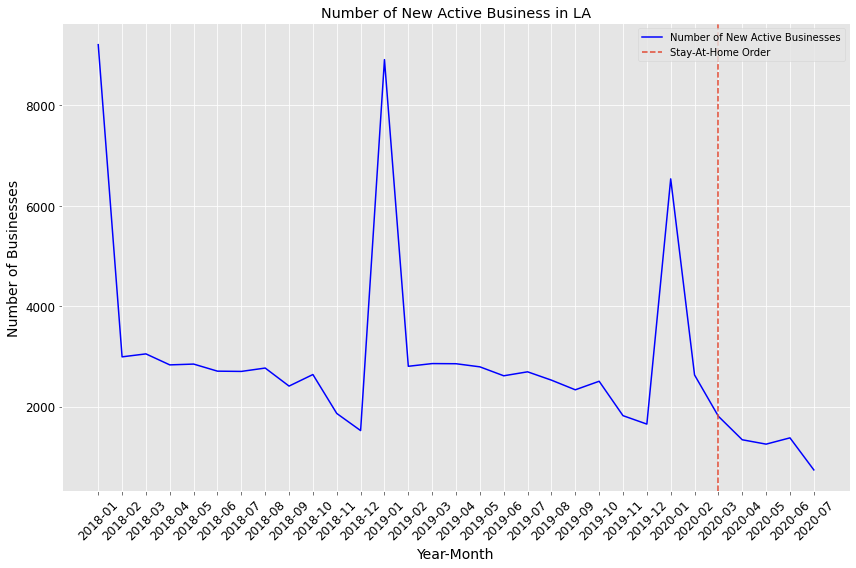

In [21]:
time = businesses_19_20.index.values
nbr_businesses = businesses_19_20.values

fig, axes = plt.subplots(1,1, figsize=(12,8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
axes.plot(time, nbr_businesses, color='blue')
axes.set_xlabel("Year-Month", color="black", fontsize=14)
axes.set_ylabel("Number of Businesses", color="black", fontsize=14)
axes.set_title("Number of New Active Business in LA",color="black")
axes.tick_params(axis="y", labelsize=12, labelcolor="black")
axes.tick_params(axis="x", labelsize=12, labelcolor="black", labelrotation=45)
axes.axvline('2020-03', 0, 1, linestyle='--', label='Stay-At-Home Order')
labels = ['Number of New Active Businesses', 'Stay-At-Home Order']
axes.legend(labels=labels, loc='upper right')

plt.tight_layout()
plt.savefig("images/figure3.png", bbox_inches='tight')   
plt.show()

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
 - A spike in new businesses occur during the winter holiday season.<br>
 - The monthly totals for 2020 are lower than those for 2018 and 2019.<br>
</div>

<hr style='border-top: 4px solid black;'>

# # <font color="blue">Question 5:</font> Is there a difference in the number of new businesses by clasification? 

In [22]:
# The total number of classifications in dataset
unique_naics_classifications = len(df['primary_naics_description'].unique())
unique_naics_classifications

291

In [23]:
# Get the top 10 business classifications
top_naics_desc = df['primary_naics_description'].value_counts()[:10].to_frame()
top_naics_desc

,primary_naics_description
All other personal services,14933
"Independent artists, writers, & performers",11343
Lessors of real estate (including mini warehouses & self-storage units),6700
Single Family Housing Construction (1997 NAICS),6677
Motion picture & video industries (except video rental),5276
"All other professional, scientific, & technical services",4781
"Management, scientific, & technical consulting services",4345
Janitorial services,3857
All other specialty trade contractors,3049
Full-service restaurants,2770


### Finter dataframe to only the top 10 NAICS

In [24]:
# Dataframe that contains only the top 10 naics
top_10_naics_names = top_naics_desc.index.values
top_10_naics_df = df[df['primary_naics_description'].isin(top_10_naics_names)]

In [25]:
# Groupby filtered dataframe for pre-pivot table step
top_10_naics_groupby = top_10_naics_df.groupby(["start_year", "primary_naics_description"])["start_year"].agg(["count"])
top_10_naics_groupby = top_10_naics_groupby.reset_index()

In [26]:
# Create a pivot table from the groupby dataframe
table_naics = pd.pivot_table(top_10_naics_groupby, values='count', index='primary_naics_description', columns=['start_year'], aggfunc='sum')
table_naics

start_year,2015,2016,2017,2018,2019,2020
primary_naics_description,,,,,,
All other personal services,2091,3156,2940,3069,2607,1070
"All other professional, scientific, & technical services",790,987,923,1004,776,301
All other specialty trade contractors,333,516,512,644,780,264
Full-service restaurants,322,435,575,603,613,222
"Independent artists, writers, & performers",1592,2488,2120,2613,1857,673
Janitorial services,537,866,708,745,736,265
Lessors of real estate (including mini warehouses & self-storage units),1371,1586,1478,1209,861,195
"Management, scientific, & technical consulting services",761,1102,869,741,638,234
Motion picture & video industries (except video rental),921,1270,1074,1036,763,212


In [27]:
pct_change_table_naics = table_naics.pct_change(axis='columns')*100
pct_change_table_naics.style.applymap(color_negative_red)

start_year,2015,2016,2017,2018,2019,2020
primary_naics_description,,,,,,
All other personal services,nan,50.9326,-6.84411,4.38776,-15.0538,-58.9567
"All other professional, scientific, & technical services",nan,24.9367,-6.4843,8.77573,-22.7092,-61.2113
All other specialty trade contractors,nan,54.955,-0.775194,25.7812,21.118,-66.1538
Full-service restaurants,nan,35.0932,32.1839,4.86957,1.65837,-63.7847
"Independent artists, writers, & performers",nan,56.2814,-14.791,23.2547,-28.9323,-63.7588
Janitorial services,nan,61.2663,-18.2448,5.22599,-1.20805,-63.9946
Lessors of real estate (including mini warehouses & self-storage units),nan,15.682,-6.80958,-18.2003,-28.7841,-77.3519
"Management, scientific, & technical consulting services",nan,44.8095,-21.1434,-14.7296,-13.9001,-63.3229
Motion picture & video industries (except video rental),nan,37.8936,-15.4331,-3.53818,-26.3514,-72.2149


In [28]:
max_change = pct_change_table_naics[2020].max()
min_change = pct_change_table_naics[2020].min()
mean_change = pct_change_table_naics[2020].mean()
max_change_city = pct_change_table_naics[pct_change_table_naics[2020] == max_change].index.values[0]
min_change_city = pct_change_table_naics[pct_change_table_naics[2020] == min_change].index.values[0]
print('The classification with the larged drop in new businesses was {} at {}%\nThe classification with the smallest drop in new business was {} at {}%\nThe mean change in the classification of new businesses was {}%'.format(max_change_city, round(max_change), min_change_city, round(min_change), round(mean_change)))

The classification with the larged drop in new businesses was All other personal services at -59.0%
The classification with the smallest drop in new business was Lessors of real estate (including mini warehouses & self-storage units) at -77.0%
The mean change in the classification of new businesses was -65.0%


<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
 - All of the top business classifications in this dataset had a negative percent change <br>
 - All other personal services had the lowest drop in new businesses at -59.0%<br>
 - Lessors of real estate (including mini warehouses and self-storage units) had the highest drop in new businesses at -77.0%<br>
 - The mean percent change in new businesses was -59%.<br>
</div>

# Is there a difference in the annual number of new businesses by clasification between Jan - July?

In [29]:
# Dataframe that contains only the top 10 naics
top_10_naics_names = top_naics_desc.index.values
top_10_naics_df = jan_july_df[jan_july_df['primary_naics_description'].isin(top_10_naics_names)]
# Groupby filtered dataframe for pre-pivot table step
top_10_naics_groupby = top_10_naics_df.groupby(["start_year", "primary_naics_description"])["start_year"].agg(["count"])
top_10_naics_groupby = top_10_naics_groupby.reset_index()
# Create a pivot table from the groupby dataframe
table_naics = pd.pivot_table(top_10_naics_groupby, values='count', index='primary_naics_description', columns=['start_year'], aggfunc='sum')
pct_change_table_naics = table_naics.pct_change(axis='columns')*100
pct_change_table_naics.style.applymap(color_negative_red)

start_year,2015,2016,2017,2018,2019,2020
primary_naics_description,,,,,,
All other personal services,nan,97.861,-11.036,1.11392,-12.4186,-40.8805
"All other professional, scientific, & technical services",nan,60.0496,-4.49612,10.3896,-22.9412,-44.8473
All other specialty trade contractors,nan,120.382,-8.3815,26.183,25.25,-49.3014
Full-service restaurants,nan,74.4361,28.4483,7.38255,7.1875,-40.5248
"Independent artists, writers, & performers",nan,118.566,-18.172,30.6176,-31.0865,-51.5328
Janitorial services,nan,107.121,-25.4111,3.60721,-4.64217,-47.4645
Lessors of real estate (including mini warehouses & self-storage units),nan,49.0683,-2.60417,-17.3262,-25.097,-67.1848
"Management, scientific, & technical consulting services",nan,78.9203,-16.6667,-22.7586,-7.8125,-45.2785
Motion picture & video industries (except video rental),nan,92.9607,-19.3133,-6.64894,-20.5128,-62.724


<hr style='border-top: 4px solid black;'>

# Entire Dataset

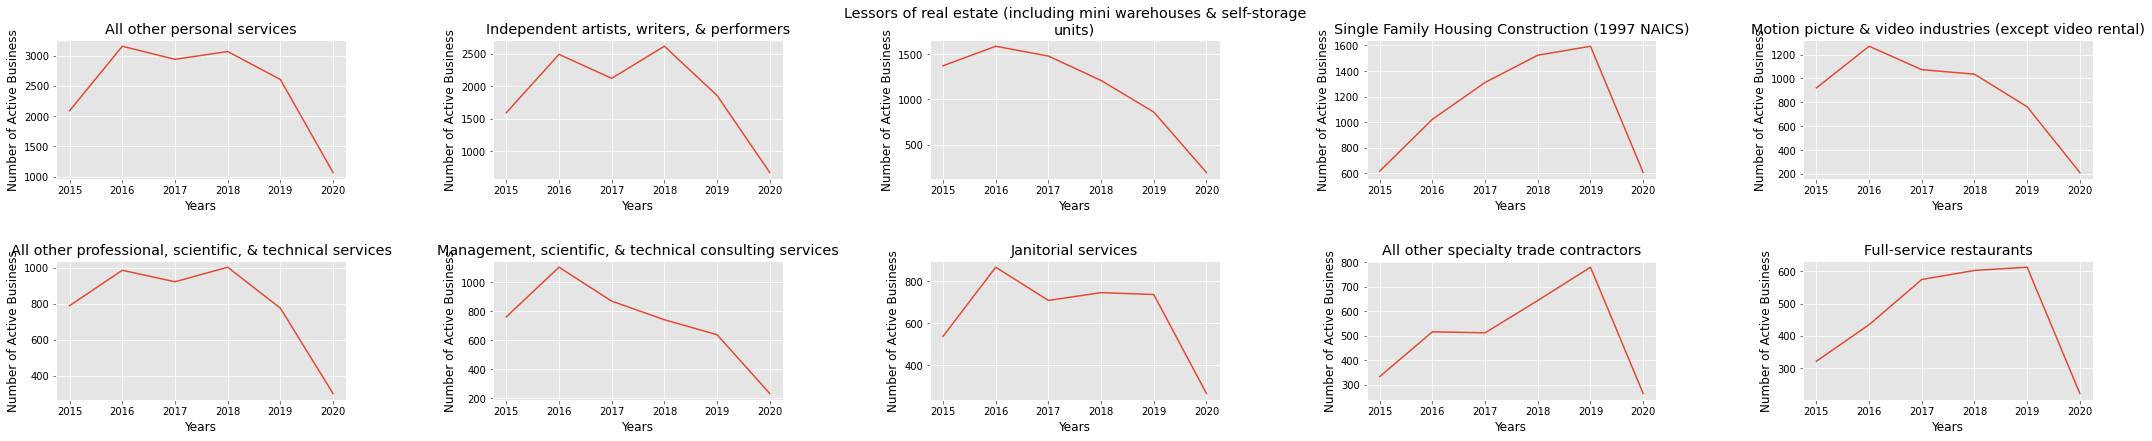

In [30]:
nbr_classifications = len(top_10_naics_names)
fig = plt.figure(figsize=(30,15))
fig.subplots_adjust(hspace=1, wspace=0.2)
for classification, num in zip(top_10_naics_names, range(1,nbr_classifications+1)):
    
    # Gets the data for the individual city
    classification_df=df[df['primary_naics_description']==classification]
    classification_year_data = classification_df.groupby('start_year').size()
    years = classification_year_data.index.values
    number_businesses = classification_year_data.values
    
    ax = fig.add_subplot(5,5, num)
    ax.plot(years, number_businesses)
    ax.set_ylabel('Number of Active Business', color="black")
    ax.set_xlabel('Years', color="black")
    ax.set_title("\n".join(wrap(classification)))
    ax.tick_params(axis="y", labelcolor="black")
    ax.tick_params(axis="x", labelcolor="black")
#     ax.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.tight_layout()
plt.savefig("images/figure4.png", bbox_inches='tight')    
plt.show()

# Jan - July Dataset

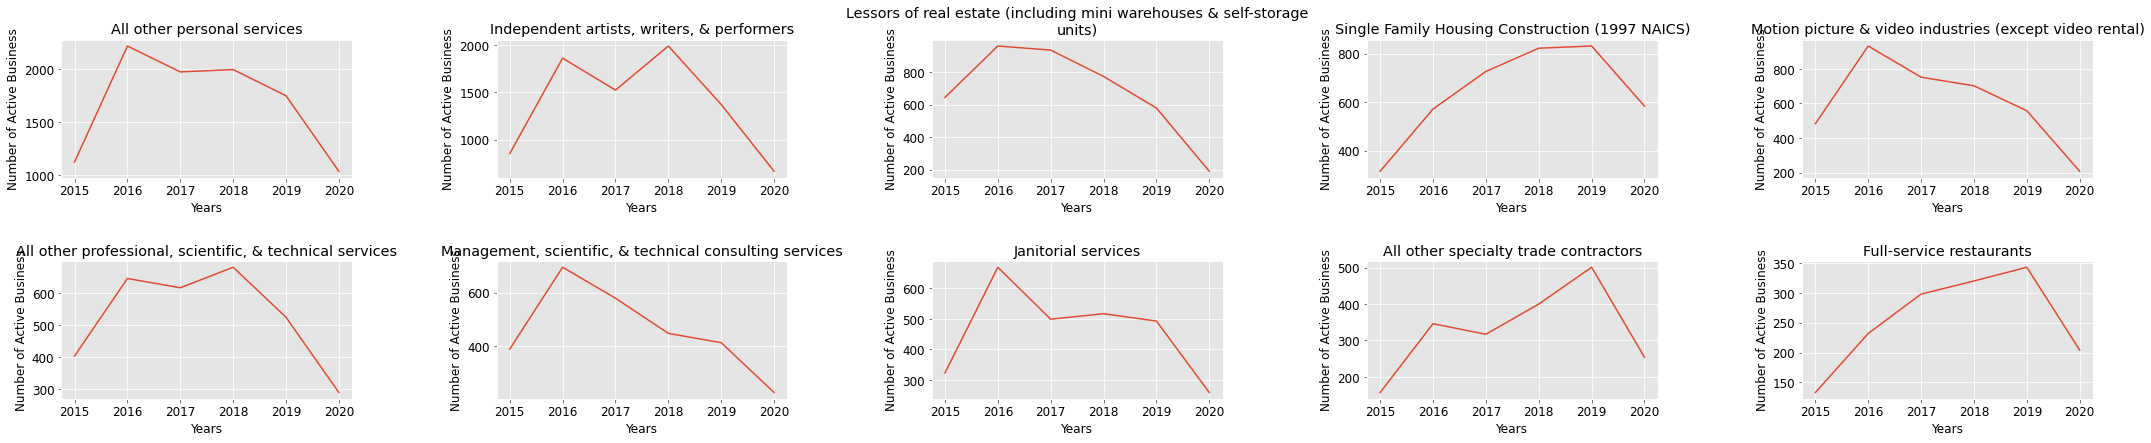

In [31]:
nbr_classifications = len(top_10_naics_names)
fig = plt.figure(figsize=(30,15))
fig.subplots_adjust(hspace=1, wspace=0.2)
for classification, num in zip(top_10_naics_names, range(1,nbr_classifications+1)):
    
    # Gets the data for the individual city
    classification_df=jan_july_df[jan_july_df['primary_naics_description']==classification]
    classification_year_data = classification_df.groupby('start_year').size()
    years = classification_year_data.index.values
    number_businesses = classification_year_data.values
    
    ax = fig.add_subplot(5,5, num)
    ax.plot(years, number_businesses)
    ax.set_ylabel('Number of Active Business', color="black")
    ax.set_xlabel('Years', color="black")
    ax.set_title("\n".join(wrap(classification)))
    ax.tick_params(axis="y", labelsize=12, labelcolor="black")
    ax.tick_params(axis="x", labelsize=12, labelcolor="black")

#     ax.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.tight_layout()
plt.savefig("images/figure4a.png", bbox_inches='tight')    
plt.show()

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
 - Most of the business classifications showed a drop between 2018 to 2019 with the exception of Single Family housing, all other specialty trade contractors, and full-service restaurants.
</div>